In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import os
from keras.utils import to_categorical
from collections import OrderedDict
from keras import backend as K
from keras.models import Model

Using TensorFlow backend.


In [2]:
from platform import python_version
print(python_version())

3.6.6


### Exp of classifing movie genres based on their events.


In [3]:
movies = pd.read_csv('../../data/metadata_events_table.tsv', sep = '\t')

In [4]:
movies.Genre_code.value_counts()

2    2375
1    1612
4     667
0     473
3     140
Name: Genre_code, dtype: int64

In [5]:
# df0 = movies[movies['Genre_code'] == 0].sample(500, replace = True)
# df1 = movies[movies['Genre_code'] == 1].sample(500)
# df2 = movies[movies['Genre_code'] == 2].sample(500)
# df3 = movies[movies['Genre_code'] == 3].sample(500)
# df4 = movies[movies['Genre_code'] == 4].sample(500)

In [6]:
# movies = pd.concat([df0, df1, df2, df3, df4])

In [7]:
len(movies)

5267

In [8]:
movies = movies.sort_values('Genre_code').reset_index()

In [9]:
{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

In [10]:
#starting and ending index for each group for plotting
action_s = min(movies[movies['Genre_code'] == 0].index.tolist())
action_e = max(movies[movies['Genre_code'] == 0].index.tolist())
comedy_s = min(movies[movies['Genre_code'] == 1].index.tolist())
comedy_e = max(movies[movies['Genre_code'] == 1].index.tolist())
drama_s = min(movies[movies['Genre_code'] == 2].index.tolist())
drama_e = max(movies[movies['Genre_code'] == 2].index.tolist())
romance_s = min(movies[movies['Genre_code'] == 3].index.tolist())
romance_e = max(movies[movies['Genre_code'] == 3].index.tolist())
thriller_s = min(movies[movies['Genre_code'] == 4].index.tolist())
thriller_e = max(movies[movies['Genre_code'] == 4].index.tolist())


In [24]:
for item in movies[movies['Genre_code'] == 4].Events.head(20).tolist():
    print(len(item.split()))
    print()

56

13

7

8

31

12

24

40

18

8

10

34

22

8

18

13

35

64

23

19



### Encode as one-hot vectors

In [12]:
t = Tokenizer()

In [13]:
events = []
for e in movies.Events.tolist():
    events.append([item.split('-')[0] for item in eval(e)])

In [14]:
# Size of data
print(len(events))

5267


In [15]:
t.fit_on_texts(events)

In [16]:
t.word_index

{'tells': 1,
 'finds': 2,
 'has': 3,
 'goes': 4,
 'tries': 5,
 'takes': 6,
 'decides': 7,
 'meets': 8,
 'becomes': 9,
 'gets': 10,
 'asks': 11,
 'include': 12,
 'sees': 13,
 'go': 14,
 'leaves': 15,
 'find': 16,
 'begins': 17,
 'get': 18,
 'comes': 19,
 'have': 20,
 'discovers': 21,
 'take': 22,
 'makes': 23,
 'says': 24,
 'realizes': 25,
 'runs': 26,
 'gives': 27,
 'leave': 28,
 'refuses': 29,
 'learns': 30,
 'arrives': 31,
 'returns': 32,
 'wants': 33,
 'manages': 34,
 'agrees': 35,
 'starts': 36,
 'attempts': 37,
 'reveals': 38,
 'see': 39,
 'falls': 40,
 'calls': 41,
 'kills': 42,
 'make': 43,
 'become': 44,
 'kill': 45,
 'meet': 46,
 'killed': 47,
 'uses': 48,
 'is': 49,
 'come': 50,
 'turns': 51,
 'had': 52,
 'shows': 53,
 'confronts': 54,
 'taken': 55,
 'escapes': 56,
 'walks': 57,
 'do': 58,
 'explains': 59,
 'forced': 60,
 'left': 61,
 'continues': 62,
 'hears': 63,
 'told': 64,
 'receives': 65,
 'offers': 66,
 'found': 67,
 'help': 68,
 'give': 69,
 'return': 70,
 'believes':

In [17]:
embedding_input_dim = max(t.word_index.values())+1

In [18]:
embedding_input_dim

5857

In [19]:
msk = np.random.rand(len(movies)) < 0.8
train = []
for e in movies[msk]['Events'].tolist():
    train.append([item.split('-')[0] for item in eval(e)])
test = []
for e in movies[~msk]['Events'].tolist():
    test.append([item.split('-')[0] for item in eval(e)])


In [25]:
x_train = t.texts_to_sequences(train)
x_train = pad_sequences(x_train, maxlen=70)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [26]:
x_train.shape

(4221, 70)

In [27]:
events_trans = t.texts_to_sequences(events)
events_trans = pad_sequences(events_trans, maxlen=70)
# events_trans = np.reshape(events_trans, (events_trans.shape[0], events_trans.shape[1], 1))

In [29]:
x_test = t.texts_to_sequences(test)
x_test = pad_sequences(x_test, maxlen=70)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [30]:
y_train = to_categorical(movies[msk]['Genre_code'].tolist())
y_test = to_categorical(movies[~msk]['Genre_code'].tolist())

### Simple LSTM 

In [31]:
# create the model
embedding_vector_length = 20
model = Sequential()
model.add(Embedding(embedding_input_dim, embedding_vector_length))
model.add( LSTM(20))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, epochs=3, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          117140    
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
Total params: 120,525
Trainable params: 120,525
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
4221/4221 [==============================] - 5s 1ms/step - loss: 1.3899 - acc: 0.4454
Epoch 2/3
4221/4221 [==============================] - 4s 953us/step - loss: 1.2409 - acc: 0.4733
Epoch 3/3
4221/4221 [==============================] - 4s 963us/step - loss: 1.0771 - acc: 0.5759


In [32]:
# Final evaluation of the model
scores = model.evaluate(x_test,
                        y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

1046/1046 [==============================] - 0s 264us/step
Accuracy: 50.86%


### Obtain embeddings

In [33]:
# #Get indimediate layer output using tensorflow backend
# get_lstm_output = K.function([model.layers[0].input], [model.layers[1].output])
# output = get_lstm_output([x_train])

In [34]:
#Alternative way, same result
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('lstm_1').output)
# intermediate_output = intermediate_layer_model.predict(x_train[0][0:])

In [35]:
vecs = []
for i in range(len(events)):
    output = intermediate_layer_model.predict(events_trans[i])
#     print(output.shape)
#     print(output[0])
#     break
    vecs.append(output[-1])


### Cluster embeddings

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [37]:
embedded = TSNE(n_components=2).fit_transform(vecs)
embedded.shape

(5267, 2)

In [38]:
{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

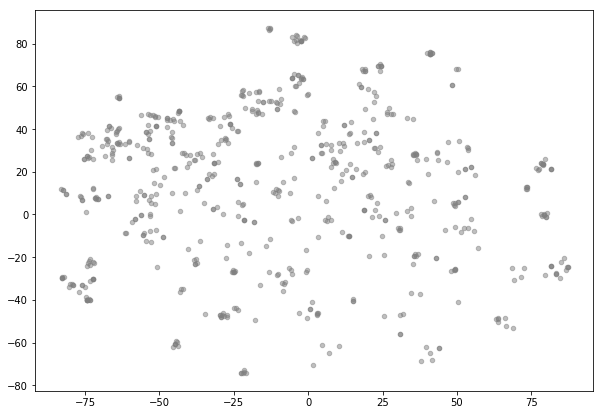

In [47]:
plt.figure(figsize = (10,7))
# plt.scatter(embedded[action_s:action_e,0], embedded[action_s:action_e,1], s = 20,color='blue', label = 'Action', alpha = 0.5)
# plt.scatter(embedded[comedy_s:comedy_e,0], embedded[comedy_s:comedy_e,1], s =20,color='yellow', label = 'Comedy', alpha = 0.5)
# plt.scatter(embedded[drama_s:drama_e,0], embedded[drama_s:drama_e,1], s = 20,color='red', label = 'Drama', alpha = 0.5)
# plt.scatter(embedded[romance_s:romance_e,0], embedded[romance_s:romance_e,1], s = 20,color='green', label = 'Romance', alpha = 0.5)
plt.scatter(embedded[thriller_s:thriller_e,0], embedded[thriller_s:thriller_e,1], s = 20,color='grey', label = 'Thriller', alpha = 0.5)
# plt.legend()

In [48]:
pca = PCA(n_components=2)
embedded = pca.fit_transform(vecs)

In [49]:
embedded.shape

(5267, 2)

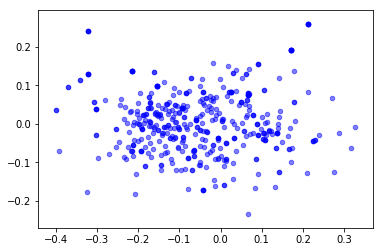

In [50]:
# plt.figure(figsize = (10,7))
plt.scatter(embedded[action_s:action_e,0], embedded[action_s:action_e,1], s = 20,color='blue', label = 'Action', alpha = 0.5)

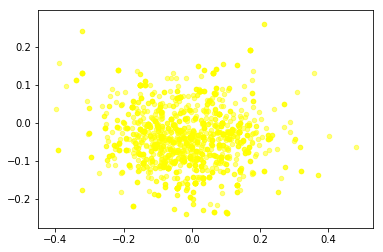

In [51]:
plt.scatter(embedded[comedy_s:comedy_e,0], embedded[comedy_s:comedy_e,1], s =20,color='yellow', label = 'Comedy', alpha = 0.5)

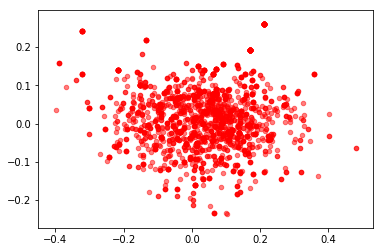

In [52]:
plt.scatter(embedded[drama_s:drama_e,0], embedded[drama_s:drama_e,1], s = 20,color='red', label = 'Drama', alpha = 0.5)

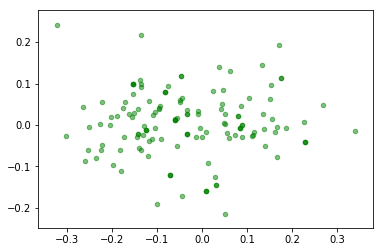

In [53]:
plt.scatter(embedded[romance_s:romance_e,0], embedded[romance_s:romance_e,1], s = 20,color='green', label = 'Romance', alpha = 0.5)

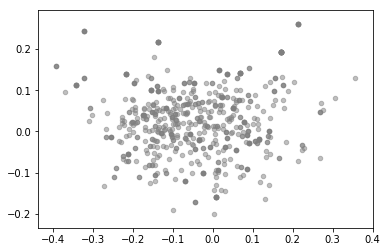

In [54]:
plt.scatter(embedded[thriller_s:thriller_e,0], embedded[thriller_s:thriller_e,1], s = 20,color='grey', label = 'Thriller', alpha = 0.5)
# plt.legend()

In [55]:
print(pca.explained_variance_ratio_)  

[0.67873807 0.29250714]


In [56]:
print(pca.singular_values_)  

[9.70968537 6.37415019]


### Baselines

In [58]:
# create the model
embedding_vector_length = 20
model = Sequential()
model.add(Embedding(embedding_input_dim, embedding_vector_length,input_length=70))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, epochs=3, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 20)            117140    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1400)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 7005      
Total params: 124,145
Trainable params: 124,145
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
4221/4221 [==============================] - 0s 101us/step - loss: 1.3298 - acc: 0.4409
Epoch 2/3
4221/4221 [==============================] - 0s 51us/step - loss: 1.2582 - acc: 0.4617
Epoch 3/3
4221/4221 [==============================] - 0s 51us/step - loss: 1.1548 - acc: 0.5380


In [60]:
# create the model
model = Sequential()
model.add(Dense(100, input_dim = 70, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, epochs=3, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               7100      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 505       
Total params: 7,605
Trainable params: 7,605
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
4221/4221 [==============================] - 0s 82us/step - loss: 10.1676 - acc: 0.3620
Epoch 2/3
4221/4221 [==============================] - 0s 24us/step - loss: 8.8685 - acc: 0.4487
Epoch 3/3
4221/4221 [==============================] - 0s 24us/step - loss: 8.8509 - acc: 0.4506
